In [22]:
from pypinyin import pinyin, lazy_pinyin, Style
import numpy as np
import pandas as pd
import sklearn
import datetime
from sklearn import linear_model, preprocessing
from matplotlib import pyplot as plt

from functools import reduce

In [2]:
# data ETL, run once and ignore afterwards
data = pd.read_excel('重资产项目清单1123-补充后数据.xlsx')
data.drop(data.columns[-2:],axis=1,inplace=True)
data.drop('项目版本', axis=1, inplace=True)
data['分数'] = np.NAN
data = data.loc[data.货地比.notnull()]

data = data.loc[data.货地比.notnull()]
data = data.loc[data['销售物业IRR（%）'].notnull()]
data = data.loc[data['保证金比例（%）'].notnull()]
data = data.loc[data['土地款支付节奏（天）'].notnull()]
data = data.loc[data['业务类型'].notnull()]
data.drop('发起立项时间', axis=1, inplace=True)

scored = pd.read_csv('analysis.csv', encoding='gbk')

for i in range(len(scored)):
    proj_id = scored.loc[i, '项目id']
    score = scored.loc[i, '分数']
    data.loc[data['项目id']==proj_id, '分数'] = score

data.to_csv('analysis2.csv', encoding='gbk', index=False)

In [23]:
samples = pd.read_csv('analysis2.csv', encoding='gbk')

In [24]:
samples[['创建时间', '拿地时间第一年']] = samples[['创建时间', '拿地时间第一年']].apply(pd.to_datetime)

In [25]:
samples['待拿地时长'] = (samples['拿地时间第一年'] - samples['创建时间']).apply(lambda dt: dt.days)

In [26]:
city_onehot = pd.get_dummies(samples['所属城市']).astype('float')
for cname in city_onehot.columns:
    samples['所属城市_' + cname] = city_onehot[cname]

In [27]:
matype_onehot = pd.get_dummies(samples['获取方式']).astype('float')
for cname in matype_onehot.columns:
    samples['获取方式_' + cname] = matype_onehot[cname]

In [28]:
btype_onehot = pd.get_dummies(samples['业务类型']).astype('float')

In [29]:
btypes = set(reduce(lambda x, y: x + y, [btype.split(',') for btype in samples['业务类型']]))

In [30]:
for btype in btypes:
    samples['业务类型_' + btype] = 0.0

In [31]:
for i in range(len(samples)):
    btype_str = samples.loc[i, '业务类型']
    for btype in btypes:
        if btype in btype_str:
            samples.loc[i, '业务类型_' + btype] = 1.0

In [32]:
samples.drop(['项目id', '项目名称', '所属城市', '所属公司', '创建时间', '业务类型', '获取方式', '拿地时间第一年'], axis=1, inplace=True)

In [33]:
y = samples['分数']
X = samples.drop('分数', axis=1)

min_max_scaler = preprocessing.MinMaxScaler()
X_minmax_scaler = min_max_scaler.fit(X)

In [34]:
training_ds = samples.loc[samples['分数'].notnull()]
test_ds = samples.loc[samples['分数'].isnull()]

In [43]:
training_ds = samples.loc[samples['分数'].notnull()]
training_ds.corr()['分数'].sort_values(ascending=False)

分数                   1.000000
销售物业IRR（%）           0.734917
货地比                  0.606358
第三年利润累计结算比例（%）       0.605491
次年累计销售比例（%）          0.519808
销售物业毛利率（%）           0.353183
所属城市_中山              0.298372
所属城市_肇庆              0.275888
获取方式_其他收并购           0.219624
所属城市_青岛              0.208025
土地款支付节奏（天）           0.200562
所属城市_沈阳              0.186391
所属城市_西安              0.173024
所属城市_江门              0.171582
所属城市_郑州              0.134679
所属城市_南宁              0.119803
所属城市_儋州              0.117186
销售物业净利率（%）           0.108126
当年累计销售比例（%）          0.100872
所属城市_清远              0.099249
所属城市_常州              0.093341
次年利润累计结算比例（%）        0.090133
所属城市_长沙              0.088010
业务类型_持有酒店            0.080450
所属城市_南京              0.080450
所属城市_合肥              0.074343
所属城市_无锡              0.070757
所属城市_济南              0.062227
所属城市_重庆              0.056218
所属城市_徐州              0.051274
                       ...   
所属城市_东莞             -0.118026
保证金比例（%）            -0.138443
所属城市_上海   

In [16]:
training_X = training_ds.drop('分数', axis=1)
training_y = training_ds['分数']

lasso = linear_model.Lasso(max_iter=1000, alpha=0.05)
model = lasso.fit(X_minmax_scaler.transform(training_X), training_y)

In [44]:
y_bar = model.predict(X_minmax_scaler.transform(training_X))
mse = (training_y.values - y_bar).std()
mse

3.331663519388421

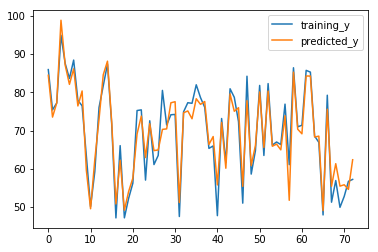

In [52]:
plt.plot(range(len(training_y)), training_y, label='training_y')
plt.plot(range(len(training_y)), y_bar, label='predicted_y')
plt.legend()
plt.show()

In [19]:
feature_importances = pd.DataFrame(model.coef_,
                                   index = X.columns,
                                   columns=['weight']).sort_values('weight',ascending=False)
feature_importances

,weight
货地比,18.852228
第三年利润累计结算比例（%）,11.941882
销售物业IRR（%）,10.773217
销售物业净利率（%）,8.290834
土地款支付节奏（天）,6.952650
所属城市_青岛,4.904665
所属城市_沈阳,4.539273
所属城市_南宁,4.016798
所属城市_江门,3.416901
计容地上建面（平米）,3.309765


ElasticNet picked 33 features and eliminated the other 42 features


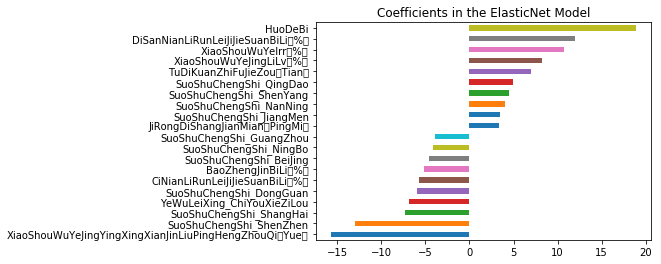

In [20]:
# Plot important coefficients
index = [''.join(map(lambda s: s.capitalize(), lazy_pinyin(s))) for s in X.columns]
coefs = pd.Series(lasso.coef_, index = index)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

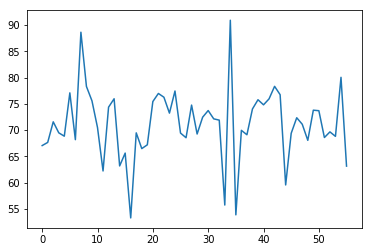

In [55]:
test_X = test_ds.drop('分数', axis=1)
test_y = test_ds['分数']

y_bar2 = model.predict(X_minmax_scaler.transform(test_X))
plt.plot(range(len(test_y)), y_bar2)
plt.show()